In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AI/lct
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AI/lct
archives      covid.ipynb  modeling	  __pycache__		utils
cancer.ipynb  data.ipynb   MSD		  studies_CT_Lung_anon	weights
configs       Lung	   pred.zip	  train_functions.py
Covid	      lung.ipynb   production.py  Untitled0.ipynb


In [2]:
import glob
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import numpy as np
import cv2
import albumentations as A
from tqdm import tqdm

!pip install -qqq segmentation_models_pytorch
from utils import Config 
from utils.cfgtools import get_model

In [3]:
!rm -rf /content/rp*

In [ ]:
!unzip archives/rp_msk.zip -d /content
!unzip archives/rp_im.zip -d /content
!cp archives/tr_im.nii.gz /content/rp_im/10.nii.gz
!cp archives/tr_mask.nii.gz /content/rp_msk/10.nii.gz

In [ ]:
cfg = Config().load('configs/lung.cfg')
lung_top_model = get_model(cfg)(cfg)

lung_top_model.load_state_dict(torch.load('weights/lung.pth'))
lung_top_model.to(torch.device('cuda'))
lung_top_model.eval()

In [6]:
def window_image(image, window_center=-600, window_width=1500):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

In [7]:
!rm -rf /content/objects

!mkdir /content/objects
!mkdir /content/objects/1
!mkdir /content/objects/2
!mkdir /content/objects/3
!mkdir /content/objects/4

In [8]:
images = glob.glob('/content/rp_im/*')
masks = glob.glob('/content/rp_msk/*')
for image_path, mask_path in tqdm(zip(images, masks)):
    msk = (nib.load(mask_path).get_fdata() > 0).astype(np.uint8)
    msk = msk.transpose(2, 1, 0)[::-1, :, :]
    
    trd = nib.load(image_path).get_fdata()
    # trd = (trd - trd.min()) / (trd.max() - trd.min())
    trd = trd.transpose(2, 1, 0)[::-1, :, :]

    slices = []
    prev_contours = []
    prev_classes = []
    mx_value = 1
    for i in range(msk.shape[0]):
        img = msk[i, :, :]
        contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # contours = [contour for contour in contours if cv2.contourArea(contour) > 100]

        classes = []
        of_slice = np.zeros(img.shape)
        for z in range(len(contours)):
            new_class = -1
            for j in range(len(prev_contours)):
                orig = np.zeros(img.shape)
                image1 = cv2.drawContours(orig.copy(), prev_contours, j, 1, 10)
                image2 = cv2.drawContours(orig.copy(), contours, z, 1, 10)
                intersection = np.logical_and(image1, image2)
                if intersection.any():
                    new_class = prev_classes[j]
                    classes.append(new_class)
                    cv2.fillPoly(of_slice, pts =[contours[z]], color=new_class)
                    break

            if new_class == -1:
                classes.append(mx_value)
                cv2.fillPoly(of_slice, pts =[contours[z]], color=mx_value)
                mx_value += 1

        slices.append(np.expand_dims(of_slice, axis=0))
        prev_classes = classes
        prev_contours = contours

    inst_covid = np.concatenate(slices)

    areas = []
    for value in np.unique(inst_covid)[1:]:
        obj = inst_covid == value
        new_trd = trd * obj
        idxs = np.nonzero(np.sum(obj, axis=(1,2)))[0]
        ax1, ax2 = idxs[0], idxs[-1]

        idxs = np.nonzero(np.sum(obj, axis=(0,2)))[0]
        cor1, cor2 = idxs[0], idxs[-1]

        idxs = np.nonzero(np.sum(obj, axis=(0,1)))[0]
        sug1, sug2 = idxs[0], idxs[-1]

        area =  (ax2 - ax1 + 1) * (cor2 - cor1 + 1) * (sug2 - sug1 + 1)  * (0.73 ** 3)
        areas.append(area)

        new_obj = new_trd[ax1:ax2+1, cor1:cor2+1, sug1:sug2+1]
        if area < 125:
            np.savez_compressed(f'/content/objects/1/{area}.npz', obj=new_obj)
        elif 125 < area < 1000:
            np.savez_compressed(f'/content/objects/2/{area}.npz', obj=new_obj)
        elif 1_000 < area < 8_000:
            np.savez_compressed(f'/content/objects/3/{area}.npz', obj=new_obj)
        else:
            np.savez_compressed(f'/content/objects/4/{area}.npz', obj=new_obj)

10it [04:50, 29.09s/it]


In [ ]:
!ls /content/objects/* | wc -l

In [ ]:
# !wget https://data.leaders2021.innoagency.ru/index.php/s/kMdsJ7LYjH1qod4/download
# !unzip download

In [ ]:
!ls studies_CT_Lung_anon/*

In [ ]:
!ls studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.00001215001001020205001001151006/1.2.643.5.1.13.13.12.2.77.8252.02101308110405141311140509080204

In [426]:
import pydicom as dicom
from tqdm import tqdm

# ex_path = 'studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.15081502041503041207050910131408/1.2.643.5.1.13.13.12.2.77.8252.10130203090305010402130115011109/*.dcm'
# ex_path = 'studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.15020212140512021200121304120202/1.2.643.5.1.13.13.12.2.77.8252.08080903101411150307131507150107/*.dcm'
# ex_path = 'studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.11041200090906141407061112021207/1.2.643.5.1.13.13.12.2.77.8252.01101510071515050404090300071315/*.dcm'
# ex_path = 'studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.10050408060607110111080708100104/1.2.643.5.1.13.13.12.2.77.8252.03010405030803120508100401121009/*.dcm'
# ex_path = 'studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.10050408060607110111080708100104/1.2.643.5.1.13.13.12.2.77.8252.13041509150810130011060401020102/*.dcm'
# ex_path = 'studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.08130715081011041407141314150206/1.2.643.5.1.13.13.12.2.77.8252.02060201000602090514120400110510/*.dcm'
# ex_path = 'studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.08130715081011041407141314150206/1.2.643.5.1.13.13.12.2.77.8252.08110401040512001415031403080302/*.dcm'
# ex_path = 'studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.04050102110908141315120011080313/1.2.643.5.1.13.13.12.2.77.8252.11060008060002061003150805060700/*.dcm'
# ex_path = 'studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.04050102110908141315120011080313/1.2.643.5.1.13.13.12.2.77.8252.14061502020805010209120610041314/*.dcm'
ex_path = 'studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.00001215001001020205001001151006/1.2.643.5.1.13.13.12.2.77.8252.02101308110405141311140509080204/*.dcm'
dcm_paths = glob.glob(ex_path)

trd = np.zeros((len(dcm_paths), 512, 512))
for path in dcm_paths:
    ds = dicom.dcmread(path)
    trd[ds.InstanceNumber-1, :, :] = ds.pixel_array
print(trd.shape)
orig_trd = trd.copy()

# trd = window_image(trd)
trd = (trd - trd.min()) / (trd.max() - trd.min())

t = A.Resize(512, 512)
inv_t = A.Resize(trd.shape[1], trd.shape[2])

(451, 512, 512)


In [427]:

batches = [x for x in np.array_split(trd, trd.shape[0] // 4 + 1, axis=0)]
# del trd
# gc.collect()

preds = []
for i, batch in enumerate(tqdm(batches)):
    batch = t(image=batch.transpose(1, 2, 0))['image']
    tensor_batch = torch.tensor(batch.astype(np.float32)).unsqueeze(0).permute(3, 0, 1, 2)
    tensor_batch = tensor_batch.to(torch.device('cuda'))
    pred = lung_top_model(tensor_batch).detach().cpu().numpy()[:, 0, :, :]
    pred = (pred > 0.5).astype(np.uint8).transpose(1, 2, 0)
    pred = inv_t(image=pred)['image']
    pred = pred.transpose(2, 0, 1).astype(np.uint8)
    for j in range(pred.shape[0]):
        ex = pred[j, :, :]
        contours, hierarchy = cv2.findContours(ex, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # plt.imshow(ex)
        # plt.show()
        f = False
        if len(contours) > 1:
            f = True
            areas = [cv2.contourArea(contours[z]) for z in range(len(contours))]
            lung_idxs = np.argpartition(areas, -2)[-2:]
            cnt1 = contours[lung_idxs[0]].squeeze(1)
            cnt2 = contours[lung_idxs[1]].squeeze(1)
            ex = cv2.medianBlur(ex, 5)
            ex1 = cv2.fillPoly(ex, pts =[cnt1, cnt2], color=(255,255,255))
            # if i == 25:
            #     plt.imshow(ex)
            #     plt.show()
        if f:
            preds.append(np.expand_dims(ex1.astype(bool), axis=0))
        else:
            preds.append(np.expand_dims(ex.astype(bool), axis=0))

# preds = preds[::-1]

predictions = np.concatenate(preds, axis=0)

mod_preds = []
for i in tqdm(range(predictions.shape[1])):
    ex = predictions[:, i, :].astype(np.uint8)
    ex = cv2.medianBlur(ex, 5)
    contours, hierarchy = cv2.findContours(ex, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 1:
        areas = [cv2.contourArea(contours[i]) for i in range(len(contours))]
        lung_idxs = np.argpartition(areas, -2)[-2:]
        cnt1 = contours[lung_idxs[0]].squeeze(1)
        cnt2 = contours[lung_idxs[1]].squeeze(1)
        cv2.fillPoly(ex, pts =[cnt1, cnt2], color=(255,255,255))
        # cv2.fillPoly(ex, pts =[cnt2], color=(2,2,2))
    mod_preds.append(np.expand_dims(ex, axis=0))    
mod_preds = np.concatenate(mod_preds, axis=0).transpose(1, 0, 2)    

100%|██████████| 512/512 [00:01<00:00, 486.40it/s]


In [428]:
# for i in range(mod_preds.shape[2]):
#     mod_preds[:, 350:, i] = 0

In [429]:
# plt.imshow(trd[:, :, 200])

In [430]:
# plt.imshow(mod_preds[:, :, 300])

In [431]:
nonzero_idxs = np.nonzero(np.sum(mod_preds, axis=(1, 2)))[0]
start_idx, end_idx = nonzero_idxs[0], nonzero_idxs[-1]

delta = (end_idx - start_idx + 1)
right_upper = start_idx + (delta // 8) * 3
right_middle = start_idx + (delta // 8) * 5
right_bottom = end_idx

left_upper = start_idx + delta // 2
left_bottom = end_idx


In [432]:
from random import randint

r1 = np.nonzero(mod_preds[:right_upper, :, :])
r1_n = randint(1, r1[0].shape[0])
r1_x = r1[0][r1_n]
r1_y = r1[1][r1_n]
r1_z = r1[2][r1_n]

r2 = np.nonzero(mod_preds[right_upper:right_middle, :, :])
r2_n = randint(1, r2[0].shape[0])
r2_x = r2[0][r2_n]
r2_y = r2[1][r2_n]
r2_z = r2[2][r2_n]


r3 = np.nonzero(mod_preds[right_middle:right_bottom, :, :])
r3_n = randint(1, r3[0].shape[0])
r3_x = r3[0][r3_n]
r3_y = r3[1][r3_n]
r3_z = r3[2][r3_n]


l1 = np.nonzero(mod_preds[:left_upper, :, :])
l1_n = randint(1, l1[0].shape[0])
l1_x = l1[0][l1_n]
l1_y = l1[1][l1_n]
l1_z = l1[2][l1_n]


l2 = np.nonzero(mod_preds[left_upper:left_bottom, :, :])
l2_n = randint(1, l2[0].shape[0])
l2_x = l2[0][l2_n]
l2_y = l2[1][l2_n]
l2_z = l2[2][l2_n]

In [353]:
# !rm -rf  /content/studies_CT_Lung_anon

In [361]:
!mkdir /content/studies_CT_Lung_anon

!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.15081502041503041207050910131408/
!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.15081502041503041207050910131408/1.2.643.5.1.13.13.12.2.77.8252.10130203090305010402130115011109/

!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.15020212140512021200121304120202/
!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.15020212140512021200121304120202/1.2.643.5.1.13.13.12.2.77.8252.08080903101411150307131507150107

!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.11041200090906141407061112021207/
!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.11041200090906141407061112021207/1.2.643.5.1.13.13.12.2.77.8252.01101510071515050404090300071315

!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.10050408060607110111080708100104/
!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.10050408060607110111080708100104/1.2.643.5.1.13.13.12.2.77.8252.03010405030803120508100401121009

!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.10050408060607110111080708100104/
!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.10050408060607110111080708100104/1.2.643.5.1.13.13.12.2.77.8252.13041509150810130011060401020102

!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.08130715081011041407141314150206/
!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.08130715081011041407141314150206/1.2.643.5.1.13.13.12.2.77.8252.02060201000602090514120400110510

!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.08130715081011041407141314150206/
!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.08130715081011041407141314150206/1.2.643.5.1.13.13.12.2.77.8252.08110401040512001415031403080302

!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.04050102110908141315120011080313/
!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.04050102110908141315120011080313/1.2.643.5.1.13.13.12.2.77.8252.11060008060002061003150805060700

!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.04050102110908141315120011080313/
!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.04050102110908141315120011080313/1.2.643.5.1.13.13.12.2.77.8252.14061502020805010209120610041314

!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.00001215001001020205001001151006/
!mkdir /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.00001215001001020205001001151006/1.2.643.5.1.13.13.12.2.77.8252.02101308110405141311140509080204

mkdir: cannot create directory ‘/content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.10050408060607110111080708100104/’: File exists
mkdir: cannot create directory ‘/content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.08130715081011041407141314150206/’: File exists
mkdir: cannot create directory ‘/content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.04050102110908141315120011080313/’: File exists


In [236]:
# /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.15081502041503041207050910131408/1.2.643.5.1.13.13.12.2.77.8252.10130203090305010402130115011109/
# super-large
# numerious

# /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.15020212140512021200121304120202/1.2.643.5.1.13.13.12.2.77.8252.08080903101411150307131507150107
# super-large
# few

# /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.11041200090906141407061112021207/1.2.643.5.1.13.13.12.2.77.8252.01101510071515050404090300071315
# single
# super-large

# /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.10050408060607110111080708100104/1.2.643.5.1.13.13.12.2.77.8252.03010405030803120508100401121009
# single
# small

# /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.10050408060607110111080708100104/1.2.643.5.1.13.13.12.2.77.8252.13041509150810130011060401020102
# single
# medium

# /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.08130715081011041407141314150206/1.2.643.5.1.13.13.12.2.77.8252.02060201000602090514120400110510
# few
# large

# /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.08130715081011041407141314150206/1.2.643.5.1.13.13.12.2.77.8252.08110401040512001415031403080302
# few
# medium

# /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.08130715081011041407141314150206/1.2.643.5.1.13.13.12.2.77.8252.08110401040512001415031403080302
# few
# small

# /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.04050102110908141315120011080313/1.2.643.5.1.13.13.12.2.77.8252.14061502020805010209120610041314
# numerious
# large

# /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.00001215001001020205001001151006/1.2.643.5.1.13.13.12.2.77.8252.02101308110405141311140509080204
# numerious
# medium

In [345]:
from random import choice


In [ ]:
str_amount = "nn"
if str_amount == "few":
    amount = randint(4, 10)
elif str_amount == "single":
    amount = 1
else:
    amount = randint(10, 15)

str_size = "medium"
if str_size == "small":
    obj_dir = '/content/objects/1/*.npz'
elif str_size == "medium":
    obj_dir = '/content/objects/2/*.npz'
elif str_size == "large":
    obj_dir = '/content/objects/3/*.npz'
else:
    obj_dir = '/content/objects/4/*.npz'

obj_paths = glob.glob(obj_dir)


for i in range(amount):
    r1_n = randint(1, r1[0].shape[0])
    r1_x = r1[0][r1_n]
    r1_y = r1[1][r1_n]
    r1_z = r1[2][r1_n]

    r2_n = randint(1, r2[0].shape[0])
    r2_x = r2[0][r2_n]
    r2_y = r2[1][r2_n]
    r2_z = r2[2][r2_n]

    r3_n = randint(1, r3[0].shape[0])
    r3_x = r3[0][r3_n]
    r3_y = r3[1][r3_n]
    r3_z = r3[2][r3_n]

    l1_n = randint(1, l1[0].shape[0])
    l1_x = l1[0][l1_n]
    l1_y = l1[1][l1_n]
    l1_z = l1[2][l1_n]

    l2_n = randint(1, l2[0].shape[0])
    l2_x = l2[0][l2_n]
    l2_y = l2[1][l2_n]
    l2_z = l2[2][l2_n]

    obj = np.load(choice(obj_paths))['obj']
    t = A.Resize(10, obj.shape[1])
    obj = t(image=obj)['image']
    end_x = min(trd.shape[0], r1_x + obj.shape[0])
    end_y = min(trd.shape[1], r1_y + obj.shape[1])
    end_z = min(trd.shape[2], r1_z + obj.shape[2])
    end_obj_x = min(trd.shape[0] - r1_x, obj.shape[0])
    end_obj_y = min(trd.shape[1] - r1_y, obj.shape[1])
    end_obj_z = min(trd.shape[2] - r1_z, obj.shape[2])

    obj = obj[:end_obj_x, :end_obj_y, :end_obj_z] * (mod_preds == 255)[r1_x:end_x, r1_y:end_y, r1_z:end_z]

    rect = orig_trd[r1_x:end_x, r1_y:end_y, r1_z:end_z]
    print(obj.shape)
    print(np.unique(obj))
    np.putmask(rect, obj != 0, rect * 0.75 + 0.25 * obj)
    orig_trd[r1_x:end_x, r1_y:end_y, r1_z:end_z] = rect


for path in dcm_paths:
    ds = dicom.dcmread(path)
    ds.PixelData = orig_trd[ds.InstanceNumber-1, :, :].astype(np.int16).tobytes()
    ds.save_as('/content/' + path)

In [ ]:
!ls /content/studies_CT_Lung_anon/*

In [ ]:
!zip -r lct_preds_smoothed.zip /content/studies_CT_Lung_anon/

In [ ]:
!zip -r infin3.zip /content/studies_CT_Lung_anon/1.2.643.5.1.13.13.12.2.77.8252.15081502041503041207050910131408/1.2.643.5.1.13.13.12.2.77.8252.10130203090305010402130115011109/

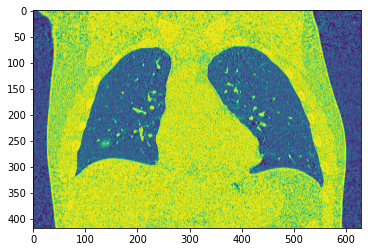

In [ ]:

trd = nib.load('/content/rp_im/3.nii.gz').get_fdata()
# trd = window_image(trd)
trd = (trd - trd.min()) / (trd.max() - trd.min())
trd = trd.transpose(2, 1, 0)[::-1, :, :]

t = A.Resize(512, 512)
inv_t = A.Resize(trd.shape[1], trd.shape[2])

slice_index = 375
plt.imshow(trd[:, 300, :])   

In [ ]:
batches = [x for x in np.array_split(trd, trd.shape[0] // 4 + 1, axis=0)]
# del trd
# gc.collect()

preds = []
for i, batch in enumerate(tqdm(batches)):
    batch = t(image=batch.transpose(1, 2, 0))['image']
    tensor_batch = torch.tensor(batch.astype(np.float32)).unsqueeze(0).permute(3, 0, 1, 2)
    tensor_batch = tensor_batch.to(torch.device('cuda'))
    pred = lung_top_model(tensor_batch).detach().cpu().numpy()[:, 0, :, :]
    pred = (pred > 0.5).astype(np.uint8).transpose(1, 2, 0)
    pred = inv_t(image=pred)['image']
    pred = pred.transpose(2, 0, 1).astype(np.uint8)
    for j in range(pred.shape[0]):
        ex = pred[j, :, :]
        contours, hierarchy = cv2.findContours(ex, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # plt.imshow(ex)
        # plt.show()
        if len(contours) > 1:
            areas = [cv2.contourArea(contours[z]) for z in range(len(contours))]
            lung_idxs = np.argpartition(areas, -2)[-2:]
            cnt1 = contours[lung_idxs[0]].squeeze(1)
            cnt2 = contours[lung_idxs[1]].squeeze(1)
            ex = cv2.medianBlur(ex, 5)
            ex1 = cv2.fillPoly(ex, pts =[cnt1, cnt2], color=(255,255,255))
            # if i == 25:
            #     plt.imshow(ex)
            #     plt.show()
            preds.append(np.expand_dims(ex1.astype(bool), axis=0))

# preds = preds[::-1]

predictions = np.concatenate(preds, axis=0)

100%|██████████| 105/105 [00:18<00:00,  5.53it/s]


In [ ]:
from tqdm import tqdm

mod_preds = []
for i in tqdm(range(predictions.shape[1])):
    ex = predictions[:, i, :].astype(np.uint8)
    ex = cv2.medianBlur(ex, 5)
    contours, hierarchy = cv2.findContours(ex, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 1:
        areas = [cv2.contourArea(contours[i]) for i in range(len(contours))]
        lung_idxs = np.argpartition(areas, -2)[-2:]
        cnt1 = contours[lung_idxs[0]].squeeze(1)
        cnt2 = contours[lung_idxs[1]].squeeze(1)
        cv2.fillPoly(ex, pts =[cnt1, cnt2], color=(255,255,255))
    mod_preds.append(np.expand_dims(ex, axis=0))    
mod_preds = np.concatenate(mod_preds, axis=0).transpose(1, 0, 2)    

100%|██████████| 630/630 [00:00<00:00, 711.55it/s]


In [ ]:
for i in range(mod_preds.shape[2]):
    mod_preds[:, 500:, i] = 0

In [ ]:
nonzero_idxs = np.nonzero(np.sum(mod_preds, axis=(1, 2)))[0]
start_idx, end_idx = nonzero_idxs[0], nonzero_idxs[-1]
start_idx, end_idx

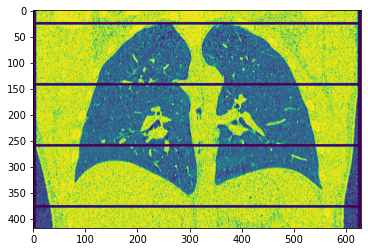

In [ ]:
# sc_trd = cv2.rotate(predictions[:, slice_index, :], cv2.ROTATE_90_COUNTERCLOCKWISE)
# sc_trd = cv2.rotate(, cv2.ROTATE_90_COUNTERCLOCKWISE)
sc_trd = (trd[:, slice_index, :] * 255).astype(np.uint8)

sc_trd = cv2.line(sc_trd, (0, start_idx), (trd.shape[1], start_idx), color=(0, 0, 0), thickness=3)
length = (end_idx - start_idx + 1)
z1 = start_idx + length // 3
z2 = end_idx - length // 3
sc_trd = cv2.line(sc_trd, (0, z1), (trd.shape[1], z1), color=(0, 0, 0), thickness=3)
sc_trd = cv2.line(sc_trd, (0, z2), (trd.shape[1], z2), color=(0, 0, 0), thickness=3)
sc_trd = cv2.line(sc_trd, (0, end_idx), (trd.shape[1], end_idx), color=(0, 0, 0), thickness=3)
plt.imshow(sc_trd)

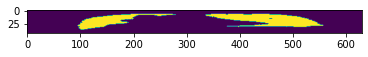

In [ ]:
trd.shape

trd = cv2.rotate(trd[:, 256, :], cv2.ROTATE_90_COUNTERCLOCKWISE)

t = A.Resize(256, 512)
inv_t = A.Resize(trd.shape[0], trd.shape[1])

trd = t(image=trd)['image']
trd = (trd - trd.min()) / (trd.max() - trd.min())
pred = predict(trd).astype(np.uint8)
plt.imshow(inv_t(image=pred)['image'])

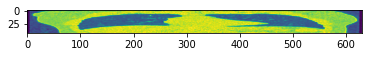

In [ ]:
plt.imshow(inv_t(image=trd)['image'])

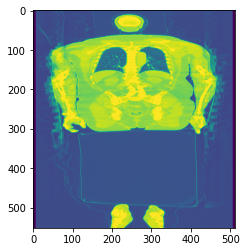

In [ ]:
plt.imshow(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))

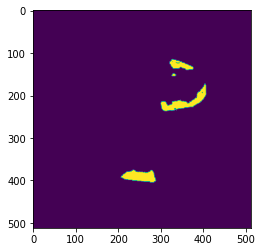

In [ ]:
trd = (nib.load('/content/rp_msk/1.nii.gz').get_fdata() > 0).astype(np.float64)
trd = t(image=trd[:, :, 25])['image']
plt.imshow(trd)

In [ ]:
k = 0
paths = glob.glob('Covid/*.npz')
for i in range(150, len(paths)):
    d = np.load(paths[i])
    k +=1
    img, mask = d['image'], d['label']
    img = (img - img.min()) / (img.max() - img.min())
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    # img  = window_image(img)
    if len(np.unique(mask)) == 1: continue

    pred = predict(img)
    contours, hierarchy = cv2.findContours(pred.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(contours[i]) for i in range(len(contours))]
    lung_idxs = np.argpartition(areas, -2)[-2:]
    cnt1 = contours[lung_idxs[0]].squeeze(1)
    cnt2 = contours[lung_idxs[1]].squeeze(1)
    min_w, max_w = cnt1[:, 0].min(), cnt1[:, 0].max()
    np.max(cnt1), np.min(cnt1)
    lung_img = cv2.drawContours((img * 255).astype(np.uint8), contours[lung_idxs[0]], -1, (0,255,0), 10)
    lung_img = cv2.drawContours(lung_img.astype(np.uint8), contours[lung_idxs[1]], -1, (0,255,0), 10)

    f, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(img)
    ax[1].imshow(lung_img)
    ax[2].imshow(mask)
    ax[3].imshow(img * mask)
    
    plt.show()